In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import glob
import cv2
import pandas as pd
from scipy.io import savemat
import torch.nn as nn 
import torch.nn.functional as F
import random
import scipy.io
import torch
import mat73
from PIL import Image
from skimage.transform import resize

print('if available',torch.cuda.is_available())
import math

print('count',torch.cuda.device_count())
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

from utils import remove_blind_region_psf0,remove_blind_region_psf7p5,remove_blind_region_minuspsf7p5
from utils import remove_randomness,clean_near_field_artifact

if available True
count 8


In [6]:
from model import build_net
Generator = build_net().to('cuda:1') 
remove_randomness(Generator)
Generator.load_state_dict(torch.load('./trained_model_states/Time_shift_DL.pt' ))

<All keys matched successfully>

### 1 reconstruct SoS

In [7]:
BEAMFORMING_SOS = 1540
CENTERIZED_VALUE_OF_OUTPUT = 1540
SCALING_FACTOR_INPUT = 100000000
SCALING_FACTOR_OUTPUT = 100
downsample_factor = 11
axial_length = 73

from scipy.ndimage import zoom
from skimage.measure import block_reduce

experimental_data_dir = './data/'

data_experimental = []
        
for label in ['abdominal','breast1','breast2']:
        image_i = np.array( [-remove_blind_region_psf7p5(mat73.loadmat((experimental_data_dir+'time_shift_map_'+label+'_psf_psf7p5'+'.mat'))[
    'phase_shift_map'])*SCALING_FACTOR_INPUT,remove_blind_region_psf0(mat73.loadmat((experimental_data_dir+'time_shift_map_'+label+'_psf_psf0'+'.mat'))[
    'phase_shift_map'])*SCALING_FACTOR_INPUT,-remove_blind_region_minuspsf7p5(mat73.loadmat((experimental_data_dir+'time_shift_map_'+label+'_psf_psfminus7p5'+'.mat'))[
    'phase_shift_map'])*SCALING_FACTOR_INPUT])
        
        image_i = np.array([block_reduce(image_i[channel], 
                    block_size=(downsample_factor, downsample_factor), func=np.mean)
                               for channel in range(image_i.shape[0])])
        image_i = np.nan_to_num(image_i, nan=0)
        image_i = torch.tensor(image_i)
        image_i = F.pad(image_i,(1,1,0,0))
        image_i = image_i[:,:axial_length,:]
        data_experimental.append(image_i)

data_experimental  = torch.stack(data_experimental)

def evaluate_on_phantom():
    Generator.eval()
    test_data_one_instance = data_experimental.to('cuda:1',dtype=torch.float)*1.5
    clean_near_field_artifact(test_data_one_instance)
    predicted_sos_experimental =(
         Generator(test_data_one_instance.to(
             'cuda:1',dtype=torch.float))*SCALING_FACTOR_OUTPUT+CENTERIZED_VALUE_OF_OUTPUT).cpu().detach().numpy()
    for pattern_i in range(len(predicted_sos_experimental)):
        predicted_sos_experimental_one_img = predicted_sos_experimental[pattern_i,0,:,19:-19]
        plt.figure();
        plt.imshow(predicted_sos_experimental_one_img,cmap='hot',vmax = 1600, vmin=1400)
        clb = plt.colorbar(label='[m/s]')
        plt.axis('off')
        plt.axis('off')


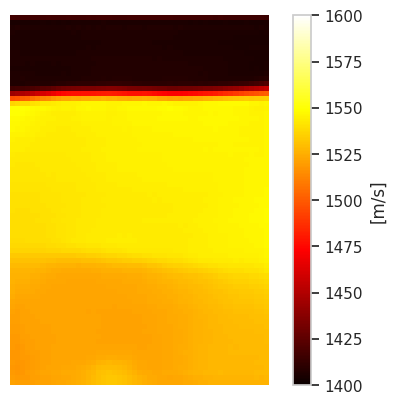

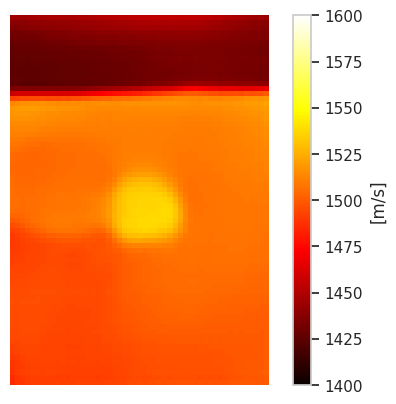

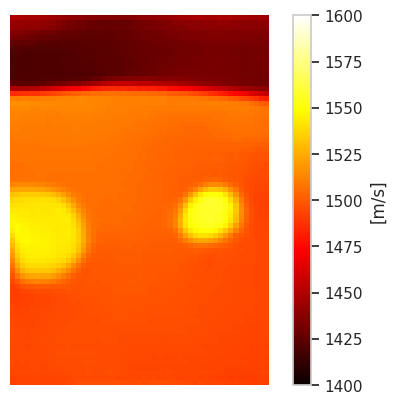

In [8]:
evaluate_on_phantom()

### 2.2 Show corresponding B-mode

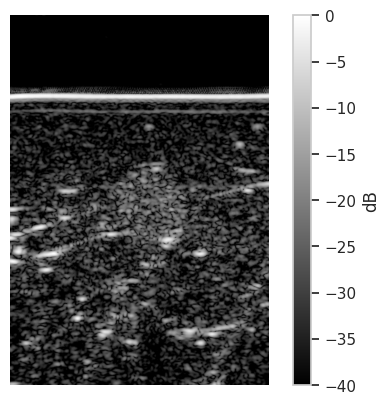

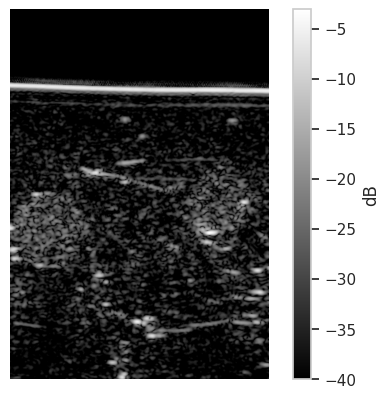

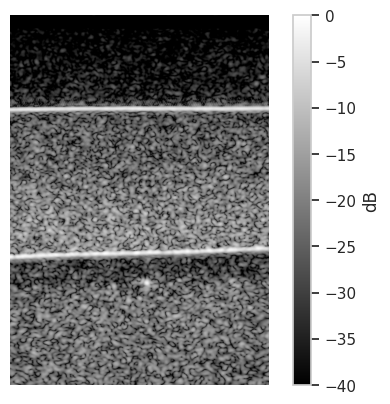

In [9]:
from utils import rf_to_bmode
from utils import extract_center_columns
lateral_length = 51

dir_BFed_RF = './data/'
for suffix_sample in ['single_inclusion','double_inclusions','abdominal']:
    beamformed_RF=scipy.io.loadmat(dir_BFed_RF+ 'beamformed_RF_for_b_mode_'+suffix_sample+'.mat')['compunded_before_b_mode']  
    dynamic_range=40
    B_mode = rf_to_bmode(beamformed_RF,dynamic_range)
    B_mode = extract_center_columns(B_mode[:axial_length*downsample_factor, :],lateral_length*downsample_factor)
    
    plt.figure()
    plt.imshow(B_mode,cmap = 'gray');
    clb = plt.colorbar(label='dB')
    plt.axis('off')
    
